# Using DeepAR to forecast electricity time-series data <a name="toc"></a>

**Estimated time: 45 min**

DeepAR is a supervised learning algorithm for forecasting scalar time series. In this notebook, we will use DeepAR to forecast the electricity demand (across different dimensions) based on time-series of past consumption. 

This notebook demonstrates how to prepare a dataset of time series for training DeepAR and how to use the trained model for inference. This content was designed to run from within a SageMaker `ml.m4.xlarge` instance.

**Table of Contents:** 

1. [Real Data Set : Electricity Consumption](#data)
    1. [Partition the data into training and test sets](#split)
    1. [Visualise the time series](#visualize)
    1. [S3 Data Formatting](#s3)
1. [DeepAR: LSTM & Monte Carlo](#deepar)
    1. [Train the model](#fit)
    1. [Create endpoint and predictor](#endpoint)
1. [Make predictions and plot results](#predict)
1. [Delete endpoint](#delete)


In [1]:
import time
whole_start = time.time()
import numpy as np
np.random.seed(1)

We will use the sagemaker client library for easy interface with sagemaker and s3fs for uploading the training data to S3. 

(Use `pip` to install missing libraries)

In [2]:
import boto3
import s3fs
import sagemaker
from sagemaker import get_execution_role

Let's start by specifying:
- The S3 bucket and prefix that you want to use for training and model data. This should be within the same region as the Notebook Instance, training, and hosting.
- The IAM role arn used to give training and hosting access to your data. See the documentation for how to create these. Here we use the `get_execution_role` function to obtain the role arn which was specified when creating the notebook.

In [3]:
bucket = '<your-s3-bucket-name-here>'
prefix = 'demos/deepar/forecast-electricity'
assert(bucket!='<your-s3-bucket-name-here>')

sagemaker_session = sagemaker.Session()
role = get_execution_role()

s3_data_path = "{}/{}/data".format(bucket, prefix)
s3_output_path = "{}/{}/output".format(bucket, prefix)
print('Data location: %s'%s3_data_path)
print('Output location: %s'%s3_output_path)

Data location: snively-sagemaker/demos/deepar/forecast-electricity/data
Output location: snively-sagemaker/demos/deepar/forecast-electricity/output


# Real Data Set : Electricity Consumption <a name="data"></a>

https://archive.ics.uci.edu/ml/datasets/Individual+household+electric+power+consumption

**Data Set Information:**

This archive contains 2075259 measurements gathered between December 2006 and November 2010 (47 months). 

**Notes:**

1. (Global_active_power*1000/60 - Sub_metering_1 - Sub_metering_2 - Sub_metering_3) represents the active energy consumed every minute (in watt hour) in the household by electrical equipment not measured in sub-meterings 1, 2 and 3. 

2. The dataset contains some missing values in the measurements (nearly 1,25% of the rows). All calendar timestamps are present in the dataset but for some timestamps, the measurement values are missing: a missing value is represented by the absence of value between two consecutive semi-colon attribute separators. For instance, the dataset shows missing values on April 28, 2007.


**Attribute Information:**

1. `Date`: Date in format dd/mm/yyyy 

2. `Time`: time in format hh:mm:ss 

3. `Global_active_power`: household global minute-averaged active power (in kilowatt) 

4. `Global_reactive_power`: household global minute-averaged reactive power (in kilowatt) 

5. `Voltage`: minute-averaged voltage (in volt) 

6. `Global_intensity`: household global minute-averaged current intensity (in ampere) 

7. `Sub_metering_1`: energy sub-metering No. 1 (in watt-hour of active energy). It corresponds to the `kitchen`, containing mainly a dishwasher, an oven and a microwave (hot plates are not electric but gas powered). 

8. `Sub_metering_2`: energy sub-metering No. 2 (in watt-hour of active energy). It corresponds to the `laundry room`, containing a washing-machine, a tumble-drier, a refrigerator and a light. 

9. `Sub_metering_3`: energy sub-metering No. 3 (in watt-hour of active energy). It corresponds to an `electric water-heater` and an `air-conditioner`.


<div style="text-align: right"> [Back to top](#toc) </div>

In [4]:
FILENAME = 'household_power_consumption.txt'

import os
if not os.path.isfile(FILENAME):
    !wget https://archive.ics.uci.edu/ml/machine-learning-databases/00235/household_power_consumption.zip
    !unzip household_power_consumption.zip

import pandas as pd
raw = pd.read_csv(FILENAME, sep=';', parse_dates=True, na_values=['?'])
raw.head()

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,16/12/2006,17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
1,16/12/2006,17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2,16/12/2006,17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
3,16/12/2006,17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
4,16/12/2006,17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0


### Convert the index of the time-series to DatetimeIndex

In order for DeepAR to model seasonalities effectively, the algorithm expects the time index in DateTime format. Additionally, all time series in the dataset have to have the same frequency

In [5]:
import datetime
raw['DateTime'] = (raw['Date']+' '+raw['Time']).map(lambda x: datetime.datetime.strptime(x, '%d/%m/%Y %H:%M:%S') )
raw.drop(['Date','Time'], axis=1, inplace=True)

cols_float = raw.drop('DateTime',axis=1).columns
raw[cols_float] = raw[cols_float].apply(lambda x: x.astype(float))
raw = raw.set_index('DateTime')

print('Percentage of missing data at minute-granularity: %2.2f%%' %(100*raw.isnull().mean().mean()) )

Percentage of missing data at minute-granularity: 1.25%


### DeepAR handles missing data

1.25% of the data at minute-granularity is missing. 

Since minute-forecasts not necessary, we will roll up to hour-granularity. This roll-up incidentally alleviates us of the missing values in our data. However, DeepAR is able to handle missing data: [DeepAR supports missing values, categorical and time-series features, and generalized frequencies](https://aws.amazon.com/blogs/machine-learning/amazon-sagemaker-deepar-now-supports-missing-values-categorical-and-time-series-features-and-generalized-frequencies/).

In [6]:
freq = '2H'
df = raw.resample(freq, convention='end').sum()
print('Percentage of missing data at hour-granularity:: %2.2f%%' %(100*df.isnull().mean().mean()) )
display(df.head())

Percentage of missing data at hour-granularity:: 0.00%


,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
DateTime,,,,,,,
2006-12-16 16:00:00,152.024,8.244,8447.18,651.6,0.0,19.0,607.0
2006-12-16 18:00:00,421.946,9.916,28068.76,1806.2,0.0,489.0,2013.0
2006-12-16 20:00:00,379.502,9.106,28273.81,1617.8,0.0,25.0,2040.0
2006-12-16 22:00:00,255.704,7.656,28762.78,1105.2,0.0,13.0,266.0
2006-12-17 00:00:00,313.912,14.362,28884.61,1342.4,0.0,1542.0,0.0


# Partition the data into training and test sets  <a name="split"></a>

In this example we want to train a model that can predict the next `1` week of electricity  time series usage. Since our time series has hourly granularity, 1 week is equivalent to 168 hours.

We also need to configure the so-called `context_length`, which determines how much context of the time series the model should take into account when making the prediction, i.e. how many previous points to look at. A typical value to start with is around the same size as the `prediction_length`. In practice, it often beneficial to use a longer `context_length`. **NB:** In addition to the `context_length` the model also takes into account the values of the time series at typical seasonal windows e.g. for hourly data the model will look at the value of the series 24h ago, one week ago one month ago etc. So it is not necessary to make the `context_length` span an entire month if you expect monthly seasonalities in your hourly data.

[Back to top](#toc)

In [7]:
prediction_length = int(7*24/int(freq.replace('H','')))
context_length = int(7*24/int(freq.replace('H','')))

print('Preditction length: %i %s' %(prediction_length, freq))
print('Context length: %i %s' %(context_length, freq))
print('-->  1 week')

n_weeks = 6
end_training = df.index[-n_weeks*prediction_length]

time_series = []
for ts in df.columns:
    time_series.append(df[ts])
    
time_series_training = []
for ts in df.columns:
    time_series_training.append(df.loc[:end_training][ts])

Preditction length: 84 2H
Context length: 84 2H
-->  1 week


## Visualise the time series <a name="visualize"></a>

Often one is interested in tuning or evaluating the model by looking at error metrics on a hold-out set. For other machine learning tasks such as classification, one typically does this by randomly separating examples into train/test sets. For forecasting it is important to do this train/test split in time rather than by series.

<div style="text-align: right"> [Back to top](#toc) </div>

In [8]:
import matplotlib
import matplotlib.pyplot as plt

cmap = matplotlib.cm.get_cmap('Spectral')
colors = cmap(np.arange(0,len(cols_float))/len(cols_float))


plt.figure(figsize=[14,8]);
for c in range(len(cols_float)):
    plt.plot(df.loc[:end_training][cols_float[c]], alpha=0.5, color=colors[c], label=cols_float[c]);  
plt.legend(loc='center left');
for c in range(len(cols_float)):
    plt.plot(df.loc[end_training:][cols_float[c]], alpha=0.25, color=colors[c], label=None);
    #plt.plot(df[cols_float[c]], alpha=0.25, color=colors[c], linestyle=':', label=None);
plt.axvline(x=end_training, color='k', linestyle=':');
plt.text(df.index[int((df.shape[0]-n_weeks*prediction_length)*0.75)], df.max().max()/2, 'Train');
plt.text(df.index[df.shape[0]-int(n_weeks*prediction_length/2)], df.max().max()/2, 'Test');
plt.xlabel('Time');

## S3 Data Formatting <a name="s3"></a>

DeepAR supports json, gzipped jsonlines, and parquet. Here we will go with json strings; the following utility functions convert `pandas.Series` objects into the JSON format that DeepAR can expects. We shall use these to write the data to S3.

<div style="text-align: right"> [Back to top](#toc) </div>

In [9]:
import json

def series_to_obj(ts, cat=None):
    obj = {"start": str(ts.index[0]), "target": list(ts)}
    if cat:
        obj["cat"] = cat
    return obj

def series_to_jsonline(ts, cat=None):
    return json.dumps(series_to_obj(ts, cat))

encoding = "utf-8"
s3filesystem = s3fs.S3FileSystem()

with s3filesystem.open(s3_data_path + "/train/train.json", 'wb') as fp:
    for ts in time_series_training:
        fp.write(series_to_jsonline(ts).encode(encoding))
        fp.write('\n'.encode(encoding))

with s3filesystem.open(s3_data_path + "/test/test.json", 'wb') as fp:
    for ts in time_series:
        fp.write(series_to_jsonline(ts).encode(encoding))
        fp.write('\n'.encode(encoding))

# DeepAR: LSTM & Monte Carlo

Amazon SageMaker's DeepAR is a methodology for producing accurate probabilistic forecasts, based on training an auto-regressive recurrent network model on a large number of related time series.  DeepAR produces more accurate forecasts than other state-of-the-art methods, while requiring minimal manual work.

* The DeepAR algorithm first tailors a `Long-Short Term Memory` (LSTM)-based recurrent neural network architecture to the data. DeepAR then produces probabilistic forecasts in the form of `Monte Carlo` simulation. 
* `Monte Carlo` samples are empirically generated pseudo-observations that can be used to compute consistent quantile estimates for all sub-ranges in the prediction horizon.
* DeepAR also uses item-similarity to handle the `Cold Start` problem, which is to make predictions for items with little or no history at all.

[Back to top](#toc)

## Train the model <a name="fit"></a>

Next, we configure the container image to be used for the region in which our notebook is running, and can now define the estimator that will launch the training job.


In [10]:
region = sagemaker_session.boto_region_name
image_name = sagemaker.amazon.amazon_estimator.get_image_uri(region, "forecasting-deepar", "latest")

estimator = sagemaker.estimator.Estimator(
    sagemaker_session=sagemaker_session,
    image_name=image_name,
    role=role,
    train_instance_count=1,
    train_instance_type='ml.c4.2xlarge',
    base_job_name='DeepAR-forecast-electricity',
    output_path="s3://" + s3_output_path
)

Next we need to set some hyperparameters: 


| Hyperparameters |  Value |  
|---|---|
|  epochs | 100  |   
|  time granularity | bi-hourly  |   
|  domain |  $\mathbb{R}^+,\mathbb{N}$ |   
|  number training examples |  8606 |   
|  batch size | 32  |   
|  learning rate | 1e-3  |   
|  LSTM layers | 3  |   
|  LSTM nodes | 40  |   
|  likelihood | gaussian  |   

Refer to the documentation for a full description of the available parameters: https://docs.aws.amazon.com/sagemaker/latest/dg/deepar_hyperparameters.html

For example, we elect the Gaussian likelihood because we have real-valued data. Other likelihood models can also readily be used, as long as samples from the distribution can cheaply be obtained, and the log-likelihood and its gradients wrt. the parameters can be evaluated. e.g.  
- **gaussian:** Use for real-valued data.

- **beta:** Use for real-valued targets between 0 and 1 inclusive.

- **negative-binomial:** Use for count data (non-negative integers).

- **student-T:** An alternative for real-valued data that works well for bursty data.

- **deterministic-L1:** A loss function that does not estimate uncertainty and only learns a point forecast.

In [11]:
hyperparameters = {
    "time_freq": freq,
    "context_length": str(context_length),
    "prediction_length": str(prediction_length),
    "num_cells": "40",
    "num_layers": "3",
    "likelihood": "gaussian",
    "epochs": "100",
    "mini_batch_size": "32",
    "learning_rate": "0.001",
    "dropout_rate": "0.05",
    "early_stopping_patience": "10"
}

estimator.set_hyperparameters(**hyperparameters)

We are ready to launch the training job. SageMaker will start an EC2 instance, download the data from S3, start training the model and save the trained model.

If you provide the `test` data channel, as we do in this example, DeepAR will also calculate accuracy metrics for the trained model on this test data set. This is done by predicting the last `prediction_length` points of each time series in the test set and comparing this to the actual value of the time series. The computed error metrics will be included as part of the log output.

**Note:** The next cell may takes **4 min** to complete. You'll notice at the end that the `billable time` is only around ~150seconds. This is because one only pays for consumption of the resources, not the provisioning time.

You can follow the progress of the training job, either in the console at [AWS SageMaker Training Jobs Console](https://console.aws.amazon.com/sagemaker/home?#/jobs), or in print out here in the notebook.



In [12]:
%%time
data_channels = {
    "train": "s3://{}/train/".format(s3_data_path),
    "test": "s3://{}/test/".format(s3_data_path)
}

estimator.fit(inputs=data_channels)

INFO:sagemaker:Creating training-job with name: DeepAR-forecast-electricity-2018-11-05-14-54-45-023


2018-11-05 14:54:45 Starting - Starting the training job...
2018-11-05 14:54:46 Starting - Launching requested ML instances......
2018-11-05 14:56:03 Starting - Preparing the instances for training......
2018-11-05 14:57:13 Downloading - Downloading input data
2018-11-05 14:57:13 Training - Downloading the training image.....
Arguments: train
[11/05/2018 14:57:59 INFO 140622283679552] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/default-input.json: {u'num_dynamic_feat': u'auto', u'dropout_rate': u'0.10', u'mini_batch_size': u'128', u'test_quantiles': u'[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]', u'_tuning_objective_metric': u'', u'_num_gpus': u'auto', u'num_eval_samples': u'100', u'learning_rate': u'0.001', u'num_cells': u'40', u'num_layers': u'2', u'embedding_dimension': u'10', u'_kvstore': u'auto', u'_num_kv_servers': u'auto', u'cardinality': u'auto', u'likelihood': u'student-t', u'early_stopping_patience': u''}
[11/05/2018 14:57:59 INFO 14

### Create endpoint and predictor <a name="endpoint"></a>

Now that we have trained a model, we can use it to perform predictions by deploying it to an endpoint. First we want to define a [sagemaker.predictor.RealTimeEndpoint](https://github.com/aws/sagemaker-python-sdk/blob/master/src/sagemaker/predictor.py) to give our endpoint more functionality and flexibility. This is the DeepARPredictor predictor class below will allow us:

* To query the endpoint and perform predictions
* To make requests using `pandas.Series` objects rather than raw JSON strings.
* To ask for specific quantiles
* The option of returning the Monte Carlo samples or not

<div style="text-align: right"> [Back to top](#toc) </div>

In [13]:
class DeepARPredictor(sagemaker.predictor.RealTimePredictor):
    
    def __init__(self, *args, **kwargs):
        super().__init__(*args, content_type=sagemaker.content_types.CONTENT_TYPE_JSON, **kwargs)
        
    def predict(self, ts, cat=None, dynamic_feat=None, 
                num_samples=100, return_samples=False, quantiles=["0.1", "0.5", "0.9"]):
        """Requests the prediction of for the time series listed in `ts`, each with the (optional)
        corresponding category listed in `cat`.
        
        ts -- `pandas.Series` object, the time series to predict
        cat -- integer, the group associated to the time series (default: None)
        num_samples -- integer, number of samples to compute at prediction time (default: 100)
        return_samples -- boolean indicating whether to include samples in the response (default: False)
        quantiles -- list of strings specifying the quantiles to compute (default: ["0.1", "0.5", "0.9"])
        
        Return value: list of `pandas.DataFrame` objects, each containing the predictions
        """
        prediction_time = ts.index[-1] + 1
        quantiles = [str(q) for q in quantiles]
        req = self.__encode_request(ts, cat, dynamic_feat, num_samples, return_samples, quantiles)
        res = super(DeepARPredictor, self).predict(req)
        return self.__decode_response(res, ts.index.freq, prediction_time, return_samples)
    
    def __encode_request(self, ts, cat, dynamic_feat, num_samples, return_samples, quantiles):
        instance = series_to_dict(ts, cat if cat is not None else None, dynamic_feat if dynamic_feat else None)

        configuration = {
            "num_samples": num_samples,
            "output_types": ["quantiles", "samples"] if return_samples else ["quantiles"],
            "quantiles": quantiles
        }
        
        http_request_data = {
            "instances": [instance],
            "configuration": configuration
        }
        
        return json.dumps(http_request_data).encode('utf-8')
    
    def __decode_response(self, response, freq, prediction_time, return_samples):
        # we only sent one time series so we only receive one in return
        # however, if possible one will pass multiple time series as predictions will then be faster
        predictions = json.loads(response.decode('utf-8'))['predictions'][0]
        prediction_length = len(next(iter(predictions['quantiles'].values())))
        prediction_index = pd.DatetimeIndex(start=prediction_time, freq=freq, periods=prediction_length)        
        if return_samples:
            dict_of_samples = {'sample_' + str(i): s for i, s in enumerate(predictions['samples'])}
        else:
            dict_of_samples = {}
        return pd.DataFrame(data={**predictions['quantiles'], **dict_of_samples}, index=prediction_index)

    def set_frequency(self, freq):
        self.freq = freq
        
def encode_target(ts):
    return [x if np.isfinite(x) else "NaN" for x in ts]        

def series_to_dict(ts, cat=None, dynamic_feat=None):
    """Given a pandas.Series object, returns a dictionary encoding the time series.

    ts -- a pands.Series object with the target time series
    cat -- an integer indicating the time series category

    Return value: a dictionary
    """
    obj = {"start": str(ts.index[0]), "target": encode_target(ts)}
    if cat is not None:
        obj["cat"] = cat
    if dynamic_feat is not None:
        obj["dynamic_feat"] = dynamic_feat        
    return obj

We're now ready to deploy our endpoint.

**Note:** This endpoint will take approximately 5 minutes to spin up. Execute the cell below and use the 5 minutes to continue reading below.

It is important to delete an endpoint once it is no longer needed; a cell at the very bottom of this notebook gives the code to do so.

In [14]:
predictor = estimator.deploy(
    initial_instance_count=1,
    instance_type='ml.m4.xlarge',
    predictor_cls=DeepARPredictor
)


INFO:sagemaker:Creating model with name: forecasting-deepar-2018-11-05-15-00-28-483
INFO:sagemaker:Creating endpoint with name DeepAR-forecast-electricity-2018-11-05-14-54-45-023


-----------------------------------------------------------------------------------!

## .... To read while the endpoint is deploying....

Let’s elaborate on the DeepAR model's architecture by walking through an example. When interested in quantifying the confidence of the estimates produced, then it's probabilistic forecasts that are wanted. The data we’re working with is real-valued, so let’s opt for the Gaussian likelihood:
$$\ell(y_t|\mu_t,\sigma_t)=\frac{1}{\sqrt{2\pi\sigma^2}}\exp{\frac{-(y_t-\mu_t)^2}{2\sigma^2}}.$$

$\theta$ represents the `parameters of the likelihood`. In the case of Gaussian, $\theta_t$ will represent the mean and standard deviation:  $$\theta_t = \{\mu_{t},\sigma_{t}\}.$$

The neural network’s last hidden layer results in $h_{d,t}$. This $h_{d,t}$ will undergo 1 activation function per likelihood parameter. For example, for the Gaussian likelihood, $h_{d,t}$ is transformed by an affine activation function to get the mean:
$$\mu_{t} = w_{\mu}^T h_{d,t} + b_{\mu},$$
and then $h$ is transformed by a softplus activation to get the standard deviation:
$$\sigma_t = \log\left(1 + \exp(w_{\sigma}^T h_{d,t} + b_{\sigma})\right).$$

The `activation parameters` are the $w_{\mu},b_{\mu},w_{\sigma},b_{\sigma}$ parameters within the activation functions. The NN is trained to learn the fixed constants of the activation parameters.  Since the $h_{d,t}$ output  vary given each time-step's input, this still allows the likelihood parameters to vary over time, and therefore capture dynamic behaviors in the time-series data.

![DeepAR Training](deepar_training.png)

From the above diagram, the <span style="color:green">green</span> input at each time-step is the data point preceding the current time-step’s data, as well as the previous network’s output. For simplicity, on this diagram we aren’t showing covariates which would also be input.

The LSTM layers are shown in <span style="color:red">red</span>, and the final hidden layer produces the $h_{d,t}$ value, which we saw in the previous slide will undergo an activation function for each parameter of the specified likelihood. To learn the activation function parameters, the NN takes the $h_{d,t}$ at time $t$ and the data up until time $t$, and performs Stochastic Gradient Descent (SGD) to yield the activation parameters which maximize the likelihood at time $t$. The <span style="color:blue">blue</span> output layer uses the SGD-optimized activation functions to output the maximum likelihood parameters.

This is how DeepAR trains its model to your data input. Now we want to DeepAR to give us probabilistic forecasts for the next time-step.

![DeepAR Forecast](deepar_forecast.png)

The <span style="color:magenta">pink</span> line marks our current point in time, divides our training data from data not yet seen. For the first input, it can use the data point of the current time. The input will be processed by the trained LSTM layers, and subsequently get activated by the optimized activation functions to output the maximum-likelihood theta parameters at time $t+1$. 

Now that DeepAR has completed the likelihood with its parameter estimates, DeepAR can simulate `Monte Carlo (MC) samples` from this likelihood and produce an empirical distribution for the predicted datapoint - the probabilistic forecasts shown in <span style="color:purple">purple</span>. The MC samples produced at time $t+1$ are used as input for time $t+2$, etc, until the end of the prediction horizon. In the interactive plots below, we'll see how Monte Carlo samples are able to provide us a confidence interval about the point estimate.




### Make predictions and plot results <a name="predict"></a>

Once the endpoint finishes deploying, we can use the previously created `predictor` object.  First, let's see its output of quantile-predictions for the time-series Global_active_power.

<div style="text-align: right"><a href="#toc">Back to top</a></div>

In [15]:
predictor.predict(ts=df.loc[end_training:, 'Global_active_power'], quantiles=[0.10, 0.5, 0.90], num_samples=100).head()


,0.1,0.5,0.9
2010-11-26 22:00:00,16.755447,101.475296,179.472717
2010-11-27 00:00:00,6.900532,58.420712,109.898125
2010-11-27 02:00:00,-21.211071,30.760900,87.504379
2010-11-27 04:00:00,-30.355915,46.410343,135.053940
2010-11-27 06:00:00,27.317589,141.479416,283.615173


In [30]:
df.loc[end_training:, 'Global_active_power'].index

DatetimeIndex(['2010-10-15 22:00:00', '2010-10-16 00:00:00',
               '2010-10-16 02:00:00', '2010-10-16 04:00:00',
               '2010-10-16 06:00:00', '2010-10-16 08:00:00',
               '2010-10-16 10:00:00', '2010-10-16 12:00:00',
               '2010-10-16 14:00:00', '2010-10-16 16:00:00',
               ...
               '2010-11-26 02:00:00', '2010-11-26 04:00:00',
               '2010-11-26 06:00:00', '2010-11-26 08:00:00',
               '2010-11-26 10:00:00', '2010-11-26 12:00:00',
               '2010-11-26 14:00:00', '2010-11-26 16:00:00',
               '2010-11-26 18:00:00', '2010-11-26 20:00:00'],
              dtype='datetime64[ns]', name='DateTime', length=504, freq='2H')

Now let's see compare the results with the actual data we kept in the test set. We include a plot function to visualize the predictions against the actual targets. 

In [16]:
import matplotlib
import matplotlib.pyplot as plt

def plot(
    predictor, 
    target_ts, 
    cat=None, 
    dynamic_feat=None, 
    forecast_date=end_training, 
    show_samples=False, 
    plot_history=7 * 12,
    confidence=80,
    num_samples=100
):
    print("Calling endpoint to generate {} predictions starting from {} ...".format(target_ts.name, str(forecast_date)))
    assert(confidence > 50 and confidence < 100)
    low_quantile = 0.5 - confidence * 0.005
    up_quantile = confidence * 0.005 + 0.5
        
    # we first construct the argument to call our model
    args = {
        "ts": target_ts[:forecast_date],
        "return_samples": show_samples,
        "quantiles": [low_quantile, 0.5, up_quantile],
        "num_samples": num_samples
    }


    if dynamic_feat is not None:
        args["dynamic_feat"] = dynamic_feat
        fig = plt.figure(figsize=(20, 6))
        ax = plt.subplot(2, 1, 1)
    else:
        fig = plt.figure(figsize=(20, 3))
        ax = plt.subplot(1,1,1)
    
    if cat is not None:
        args["cat"] = cat
        ax.text(0.9, 0.9, 'cat = {}'.format(cat), transform=ax.transAxes)

    # call the end point to get the prediction
    prediction = predictor.predict(**args)

    # plot the samples
    mccolor = 'blue'
    if show_samples: 
        for key in prediction.keys():
            if "sample" in key:
                prediction[key].plot(color='lightskyblue', alpha=0.2, label='_nolegend_')
                #prediction[key].plot(color='light'+mccolor.replace('dark',''), alpha=0.2, label='_nolegend_')
                
                
    # plot the target
    target_section = target_ts[forecast_date-plot_history:forecast_date+prediction_length]
    target_section.plot(color="black", label='target')
    plt.title(target_ts.name.upper(), color='darkred')
    
    # plot the confidence interval and the median predicted
    ax.fill_between(
        prediction[str(low_quantile)].index, 
        prediction[str(low_quantile)].values, 
        prediction[str(up_quantile)].values, 
        color=mccolor, alpha=0.3, label='{}% confidence interval'.format(confidence)
    )
    prediction["0.5"].plot(color=mccolor, label='P50')
    ax.legend(loc=2)    
    
    # fix the scale as the samples may change it
    ax.set_ylim(target_section.min() * 0.5, target_section.max() * 1.5)
    
    if dynamic_feat is not None:
        for i, f in enumerate(dynamic_feat, start=1):
            ax = plt.subplot(len(dynamic_feat) * 2, 1, len(dynamic_feat) + i, sharex=ax)
            feat_ts = pd.Series(
                index=pd.DatetimeIndex(start=target_ts.index[0], freq=target_ts.index.freq, periods=len(f)),
                data=f
            )
            feat_ts[forecast_date-plot_history:forecast_date+prediction_length].plot(ax=ax, color='g')

Below is an interactive plot, where you can explore different confidence intervals, forecast days, and Monte Carlo samples. For completeness, the Monte Carlo probabilistic forecasts for all seven time-series are plotted farther below.

In [17]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from ipywidgets import IntSlider, FloatSlider, Checkbox

style = {'description_width': 'initial'}

@interact_manual(
    series_id=IntSlider(min=0, max=len(time_series_training)-1, value=6, style=style), 
    forecast_day=IntSlider(min=0, max=100, value=0, style=style),
    confidence=IntSlider(min=60, max=95, value=80, step=5, style=style),
    history_weeks_plot=IntSlider(min=1, max=20, value=1, style=style),
    num_samples=IntSlider(min=100, max=1000, value=100, step=500, style=style),
    show_samples=Checkbox(value=True),
    continuous_update=False
)
def plot_interact(series_id, forecast_day, confidence, history_weeks_plot, show_samples, num_samples):
    plot(
        predictor,
        target_ts=time_series[series_id],
        forecast_date=end_training + datetime.timedelta(days=forecast_day),
        show_samples=show_samples,
        plot_history=history_weeks_plot * prediction_length,
        confidence=confidence,
        num_samples=num_samples
    )

interactive(children=(IntSlider(value=6, description='series_id', max=6, style=SliderStyle(description_width='…

Calling endpoint to generate Global_active_power predictions starting from 2010-10-15 22:00:00 ...
Calling endpoint to generate Global_reactive_power predictions starting from 2010-10-15 22:00:00 ...
Calling endpoint to generate Voltage predictions starting from 2010-10-15 22:00:00 ...
Calling endpoint to generate Global_intensity predictions starting from 2010-10-15 22:00:00 ...
Calling endpoint to generate Sub_metering_1 predictions starting from 2010-10-15 22:00:00 ...
Calling endpoint to generate Sub_metering_2 predictions starting from 2010-10-15 22:00:00 ...
Calling endpoint to generate Sub_metering_3 predictions starting from 2010-10-15 22:00:00 ...


<Figure size 432x288 with 0 Axes>

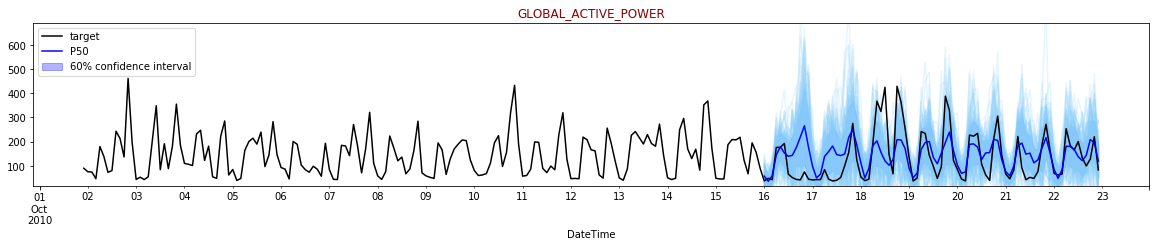

<Figure size 432x288 with 0 Axes>

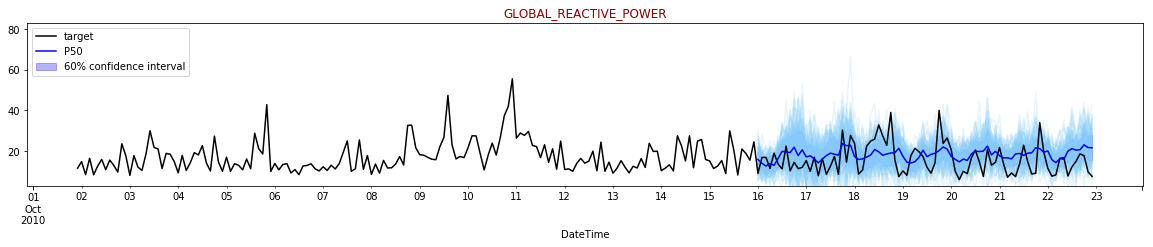

<Figure size 432x288 with 0 Axes>

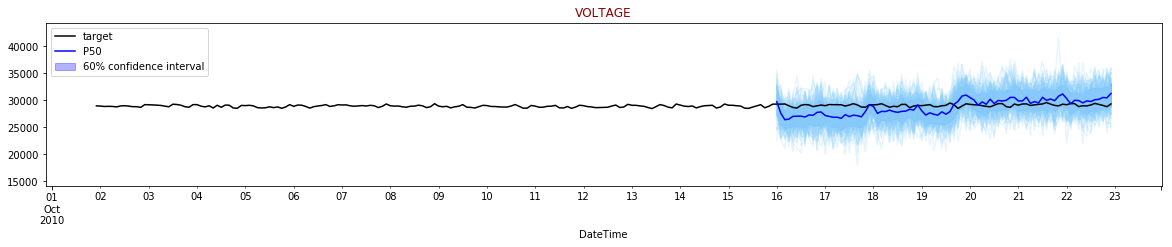

<Figure size 432x288 with 0 Axes>

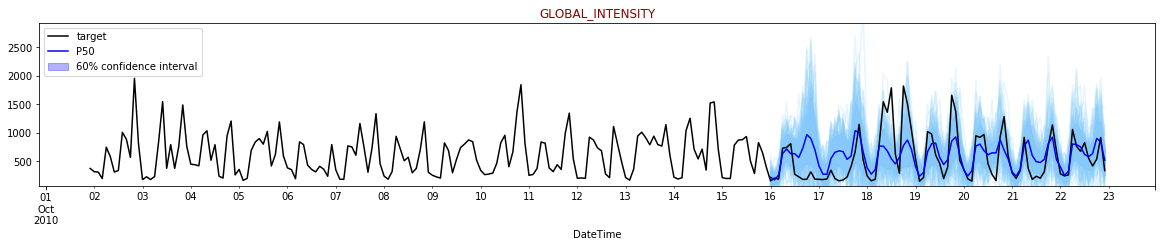

<Figure size 432x288 with 0 Axes>

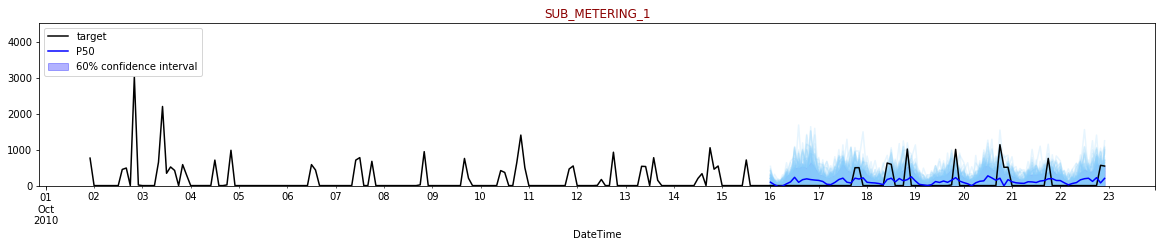

<Figure size 432x288 with 0 Axes>

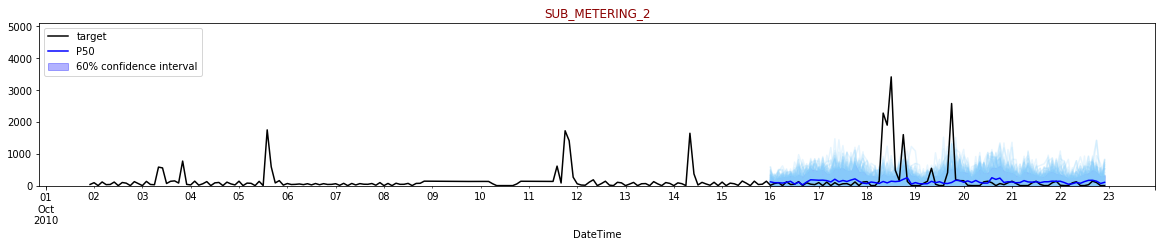

<Figure size 432x288 with 0 Axes>

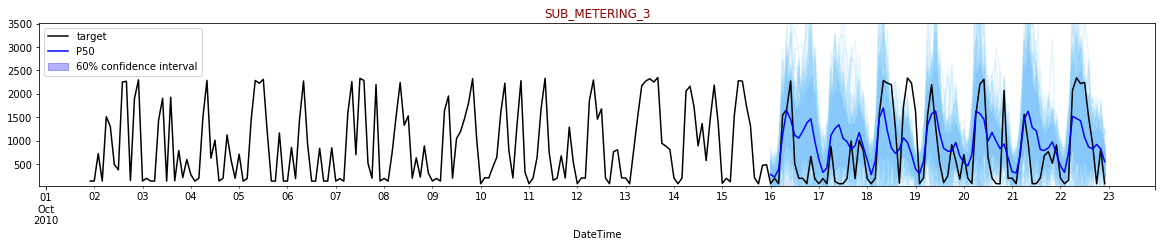

In [18]:
for i in range(len(time_series_training)):
    plt.figure()
    plot(
        predictor,
        target_ts=time_series[i],
        forecast_date=end_training,
        show_samples=True,
        plot_history= 2 * prediction_length,
        confidence=60,
    );

### Delete endpoint <a name="delete"></a>

Remember to delete an endpoint once it is no longer needed. 

[Back to top](#toc)

In [19]:
#sagemaker_session.delete_endpoint(endpoint_name)

In [20]:
#whole_end = time.time()
#print('Whole notebook elapsed time (min):', (whole_end-whole_start)/60.)

# Thank you

<div style="text-align: right"> END. OF. LAB. </div>